In [1]:
from transform import transform_data
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Load the connection string from the .env file
load_dotenv()
connection_string = os.getenv("MONGO_CONNECTION_STRING")

# Fetch and transform the data
transformed_df = transform_data(connection_string)
print(transformed_df.shape)

Retrieved 102930 rows from MongoDB.
Basic data transformation completed.
(102930, 7)


# Silver Level

In [3]:
transformed_df.dtypes

transaction_date           object
ticker                     object
executive_title            object
security_type              object
acquisition_or_disposal     int64
shares                     object
share_price                object
dtype: object

In [4]:
transformed_df['share_price'] = pd.to_numeric(transformed_df['share_price'])
transformed_df['transaction_date'] = pd.to_datetime(transformed_df['transaction_date'])
transformed_df['shares'] = pd.to_numeric(transformed_df['shares'])

In [5]:
transformed_df.dtypes

transaction_date           datetime64[ns]
ticker                             object
executive_title                    object
security_type                      object
acquisition_or_disposal             int64
shares                            float64
share_price                       float64
dtype: object

In [6]:
# Calculate percentage change
transformed_df['price_change'] = transformed_df['share_price'].pct_change()

# Replace inf values with NaN
transformed_df['price_change'].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Create the stock movement column
transformed_df['stock_movement'] = transformed_df['price_change'].apply(lambda x: 1 if x > 0 else 0)

# Drop rows with NaN in price_change or stock_movement
transformed_df.dropna(subset=['price_change', 'stock_movement'], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_22080\3834513144.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  transformed_df['price_change'] = transformed_df['share_price'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_22080\3834513144.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transformed_df['price_change'].re

In [7]:
transformed_df.head(3)

,transaction_date,ticker,executive_title,security_type,acquisition_or_disposal,shares,share_price,price_change,stock_movement
1,2024-12-11,META,"Director, COB and CEO, 10% Owner",Class A Common Stock,0,880.0,630.0615,-0.002317,0
2,2024-12-11,META,"Director, COB and CEO, 10% Owner",Class A Common Stock,0,396.0,628.4396,-0.002574,0
3,2024-12-11,META,"Director, COB and CEO, 10% Owner",Class A Common Stock,0,100.0,627.1600,-0.002036,0


In [8]:
transformed_df.isna().sum()

transaction_date              0
ticker                        0
executive_title               0
security_type                 0
acquisition_or_disposal       0
shares                        2
share_price                2486
price_change                  0
stock_movement                0
dtype: int64

In [9]:
transformed_df.dropna(inplace=True)

In [10]:
transformed_df.shape

(69804, 9)

Deep Learning Model Preparation

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras import Sequential

In [12]:
# Separate features and target
X = transformed_df[['ticker', 'executive_title', 'security_type', 'acquisition_or_disposal','shares', 'share_price']]
y = transformed_df['stock_movement']

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False)
X_categorical = encoder.fit_transform(X[['ticker', 'executive_title', 'security_type']])

# Normalize the numerical columns
scaler = MinMaxScaler()
X_numerical = scaler.fit_transform(X[['shares','share_price']])

# Combine categorical and numerical features
import numpy as np
X_processed = np.hstack([X_categorical, X_numerical])

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_processed,y, test_size=0.2,random_state=42)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Gold Level: Model 1

In [13]:
model = Sequential([
    keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'),
    keras.layers.Dropout(0.3,),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,y_train,epochs=20,batch_size=32)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6305 - loss: 0.6049
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6550 - loss: 0.5718
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6600 - loss: 0.5679
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6568 - loss: 0.5699
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6538 - loss: 0.5697
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6627 - loss: 0.5671
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6620 - loss: 0.5667
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6564 - loss: 0.5681
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6626 - loss: 0.5659
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6611 - loss: 0.5678
Epoch 11/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6583 - loss: 0.5673
Epoch 12/20
1746/1746 ━━━━━━━━

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6510 - loss: 0.5856
Test Accuracy: 0.65


# Gold Level: Visualization

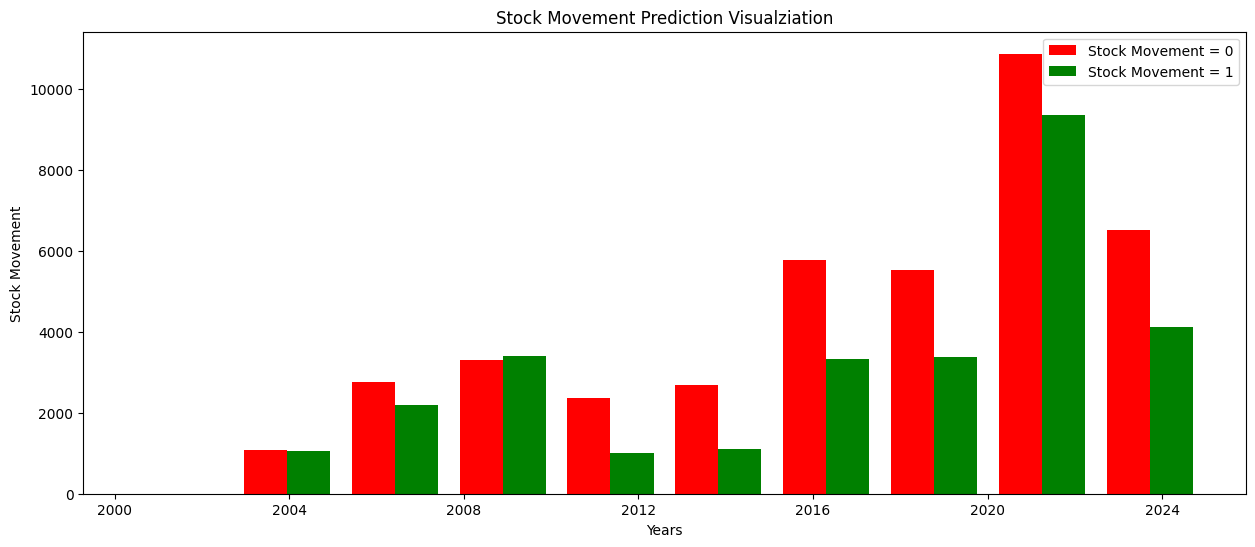

In [15]:
stock_movement_0 = transformed_df[transformed_df['stock_movement'] == 0].transaction_date
stock_movement_1 = transformed_df[transformed_df['stock_movement'] == 1].transaction_date

plt.figure(figsize=(15,6))
plt.xlabel("Years")
plt.ylabel("Stock Movement")
plt.title("Stock Movement Prediction Visualziation")
plt.hist([stock_movement_0,stock_movement_1],color=['red','green'],label=['Stock Movement = 0','Stock Movement = 1'])
plt.legend()

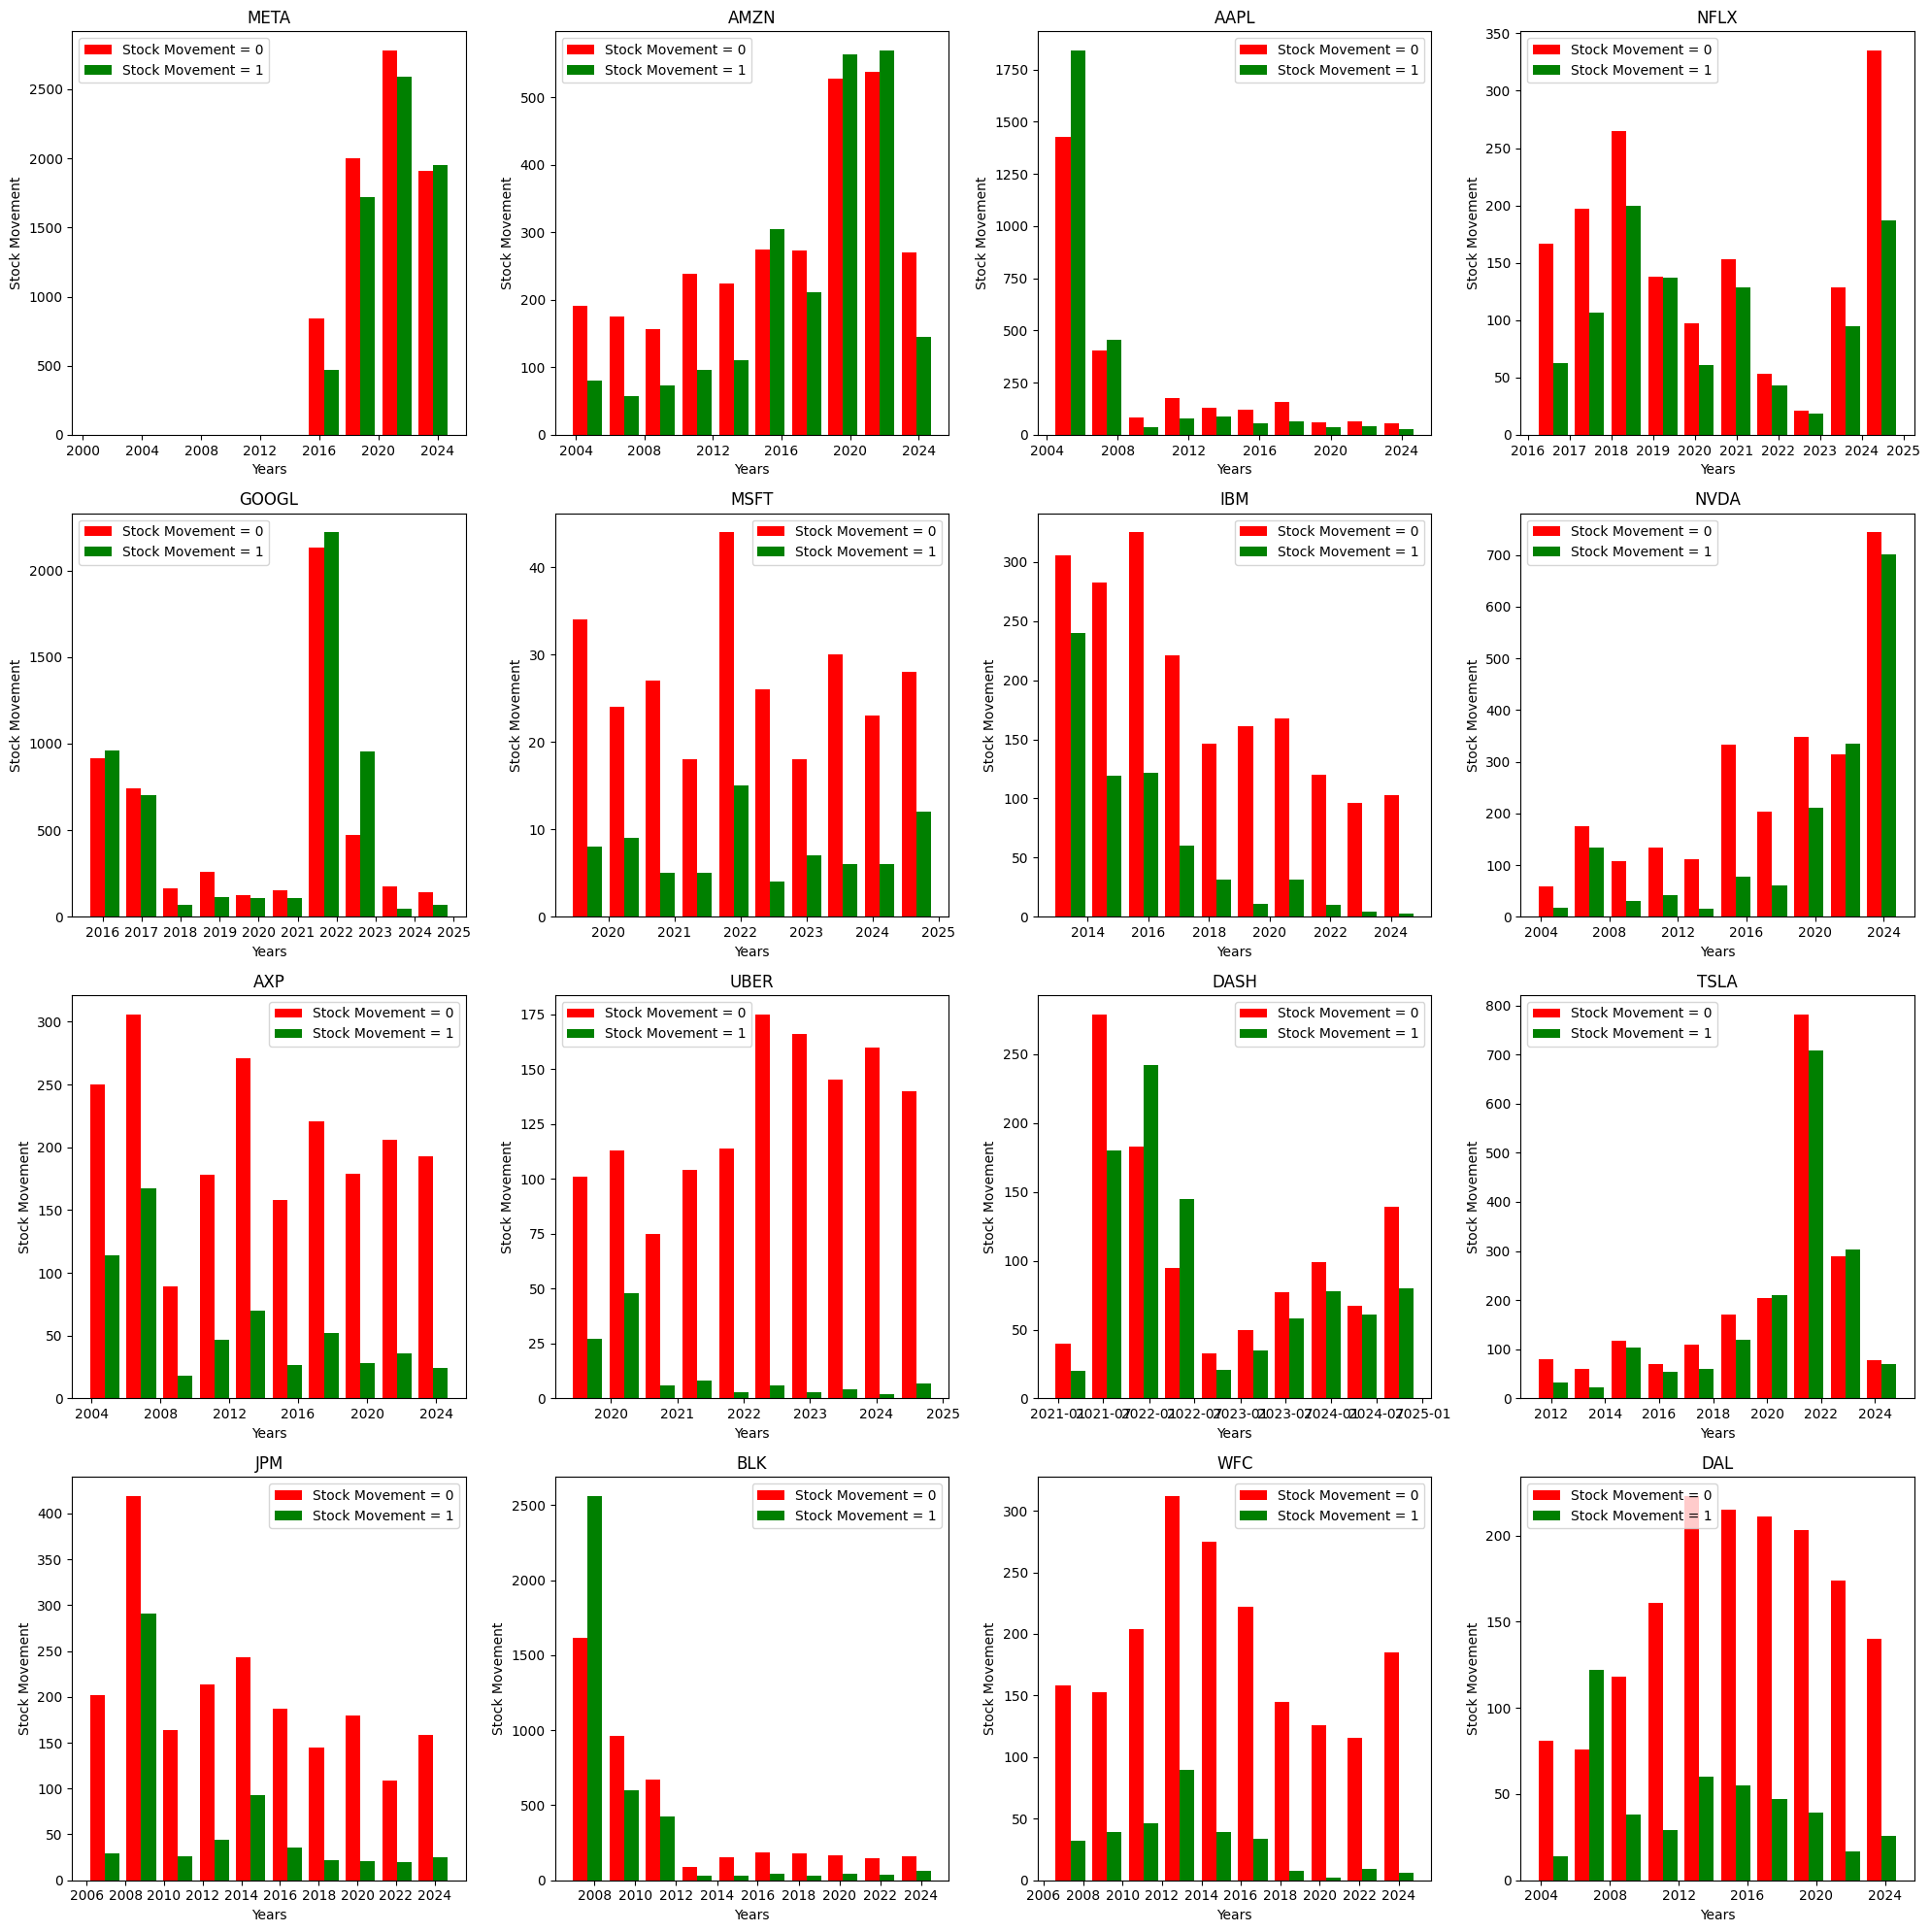

In [16]:
import matplotlib.pyplot as plt
import math

# List of company tickers
tickers = ["META", "AMZN", "AAPL", "NFLX", "GOOGL", "MSFT", "IBM", "NVDA", 
           "AXP", "UBER", "DASH", "TSLA", "JPM", "BLK", "WFC", "DAL"]

# Number of rows and columns for subplots
n_cols = 4  # Adjust columns as needed
n_rows = math.ceil(len(tickers) / n_cols)

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()  # Flatten in case of a 2D array of axes

# Iterate over each ticker and its corresponding subplot
for i, ticker in enumerate(tickers):
    # Filter data for the specific company
    company_data = transformed_df[transformed_df['ticker'] == ticker]
    stock_movement_0 = company_data[company_data['stock_movement'] == 0].transaction_date
    stock_movement_1 = company_data[company_data['stock_movement'] == 1].transaction_date

    # Plot histogram in the corresponding subplot
    axes[i].hist([stock_movement_0, stock_movement_1], 
                 color=['red', 'green'], 
                 label=['Stock Movement = 0', 'Stock Movement = 1'])
    axes[i].set_title(f"{ticker}")
    axes[i].set_xlabel("Years")
    axes[i].set_ylabel("Stock Movement")
    axes[i].legend()

# Hide unused subplots if any
for j in range(len(tickers), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


In [17]:
transformed_df['stock_movement'].value_counts()

stock_movement
0    40876
1    28928
Name: count, dtype: int64

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_processed,y)

y_sm.value_counts()

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


stock_movement
0    40876
1    40876
Name: count, dtype: int64

In [20]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm,y_sm,test_size=0.2,random_state=42)

# Gold Level: Model 2

In [21]:
model_sm = Sequential([
    keras.layers.Dense(128,input_shape=(X_train_sm.shape[1],),activation='relu'),
    keras.layers.Dropout(0.3,),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1,activation='sigmoid')
])

model_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_sm.fit(X_train_sm,y_train_sm,epochs=20,batch_size=32)

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6509 - loss: 0.6112
Epoch 2/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6711 - loss: 0.5809
Epoch 3/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6752 - loss: 0.5775
Epoch 4/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6774 - loss: 0.5752
Epoch 5/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6745 - loss: 0.5747
Epoch 6/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6771 - loss: 0.5729
Epoch 7/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6758 - loss: 0.5751
Epoch 8/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6843 - loss: 0.5696
Epoch 9/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6757 - loss: 0.5733
Epoch 10/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6764 - loss: 0.5730
Epoch 11/20
2044/2044 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6756 - loss: 0.5743
Epoch 12/20
2044/2044 ━━━━━━━

In [22]:
loss, accuracy = model_sm.evaluate(X_test_sm, y_test_sm)
print(f"Test Accuracy: {accuracy:.2f}")

511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6664 - loss: 0.5809
Test Accuracy: 0.67
